

```
# Importacion de la información
```



In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()

Saving Inflacion_Honduras.csv to Inflacion_Honduras.csv


In [ ]:
import pandas as pd 
import io 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
  
data = pd.read_csv(io.BytesIO(uploaded['Inflacion_Honduras.csv'])) 
print(data)

           Date  Inflacion
0    1992-01-01      16.53
1    1992-02-01      14.09
2    1992-03-01      12.83
3    1992-04-01      10.37
4    1992-05-01       9.52
..          ...        ...
362  2022-03-01       6.96
363  2022-04-01       8.35
364  2022-05-01       9.09
365  2022-06-01      10.22
366  2022-07-01      10.86

[367 rows x 2 columns]


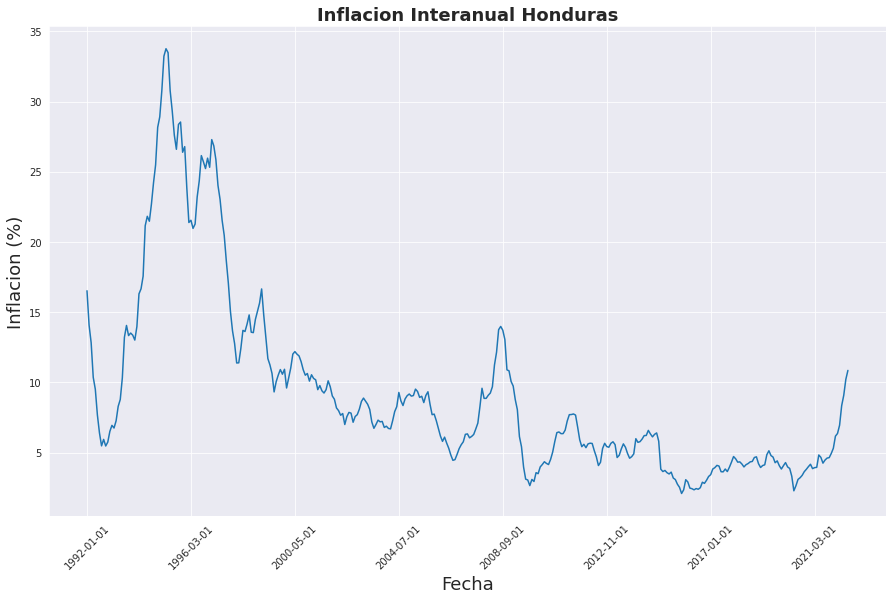

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(data["Inflacion"])
plt.xticks(range(0,data.shape[0],50),data["Date"].loc[::50], rotation = 45)
plt.title("Inflacion Interanual Honduras" , fontsize = 18, fontweight = "bold")
plt.xlabel("Fecha", fontsize=18)
plt.ylabel("Inflacion (%)", fontsize=18)
plt.show()



```
# Normalizamos la Data
```



In [ ]:
precio = data[['Inflacion']]
precio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflacion  367 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
precio['Inflacion'] = scaler.fit_transform(precio['Inflacion'].values.reshape(-1,1))

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(precio, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (278, 19, 1)
y_train.shape =  (278, 1)
x_test.shape =  (69, 19, 1)
y_test.shape =  (69, 1)


In [ ]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 30
num_layers = 8
output_dim = 1
num_epochs = 140

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Tiempo de entrenamiento: {}".format(training_time))

Epoch  0 MSE:  0.3220313489437103
Epoch  1 MSE:  0.2407102733850479
Epoch  2 MSE:  0.20221230387687683
Epoch  3 MSE:  0.2555117905139923
Epoch  4 MSE:  0.20654264092445374
Epoch  5 MSE:  0.20201866328716278
Epoch  6 MSE:  0.20650368928909302
Epoch  7 MSE:  0.2094888836145401
Epoch  8 MSE:  0.20981496572494507
Epoch  9 MSE:  0.20833396911621094
Epoch  10 MSE:  0.206038236618042
Epoch  11 MSE:  0.2036682516336441
Epoch  12 MSE:  0.20163291692733765
Epoch  13 MSE:  0.1999095231294632
Epoch  14 MSE:  0.19795174896717072
Epoch  15 MSE:  0.1948513388633728
Epoch  16 MSE:  0.188650444149971
Epoch  17 MSE:  0.1815640926361084
Epoch  18 MSE:  0.17650258541107178
Epoch  19 MSE:  0.17068223655223846
Epoch  20 MSE:  0.1585233360528946
Epoch  21 MSE:  0.14857029914855957
Epoch  22 MSE:  0.13888834416866302
Epoch  23 MSE:  0.12825530767440796
Epoch  24 MSE:  0.11284758150577545
Epoch  25 MSE:  0.10633675009012222
Epoch  26 MSE:  0.08729465305805206
Epoch  27 MSE:  0.07495427131652832
Epoch  28 MSE: 

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))



```
# Revision de las predicciones
```



In [ ]:
pronostico_lstm = pd.DataFrame()
pronostico_lstm["Obseraciones"] = original[0]
pronostico_lstm["Pronostico"]   = predict[0]
pronostico_lstm["Loss"]         =  original[0] -  predict[0]
pronostico_lstm

,Obseraciones,Pronostico,Loss
0,14.060000,13.632194,0.427807
1,13.339999,14.358009,-1.018010
2,13.520000,13.201500,0.318500
3,13.370001,13.094711,0.275290
4,13.020000,13.263091,-0.243091
...,...,...,...
273,2.360000,2.463553,-0.103553
274,2.450000,2.372703,0.077297
275,2.400000,2.484271,-0.084270
276,2.510000,2.424149,0.085851


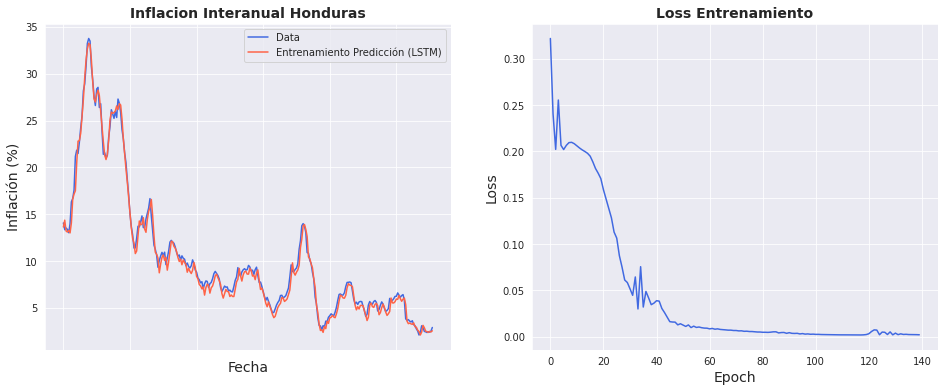

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Entrenamiento Predicción (LSTM)", color='tomato')
ax.set_title('Inflacion Interanual Honduras', size = 14, fontweight='bold')
ax.set_xlabel("Fecha", size = 14)
ax.set_ylabel("Inflación (%)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Loss Entrenamiento", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Puntuación Entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Puntuación Test: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Puntuación Entrenamiento: 0.68 RMSE
Puntuación Test: 0.46 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(precio)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(precio)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(precio)-1, :] = y_test_pred

original = scaler.inverse_transform(precio['Inflacion'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Predicción Train')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Predicción Test'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Valores Actuales')))
fig.update_layout(
    xaxis=dict(
        title_text = "Tiempo",
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Inflacion (%)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Resultados (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()



```
# Plot Dinamico con credenciales Pyplot
```



In [ ]:
pip install chart_studio

In [ ]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='Jisaula', api_key='N7TjAqxF7YSxv7SXtDeW')
py.iplot(fig, filename='Inflacion_prediction_lstm')

# MODELO GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.38990601897239685
Epoch  1 MSE:  0.20521526038646698
Epoch  2 MSE:  0.35021570324897766
Epoch  3 MSE:  0.2005477100610733
Epoch  4 MSE:  0.2164641171693802
Epoch  5 MSE:  0.2242172807455063
Epoch  6 MSE:  0.20424693822860718
Epoch  7 MSE:  0.16761985421180725
Epoch  8 MSE:  0.12706343829631805
Epoch  9 MSE:  0.11199609190225601
Epoch  10 MSE:  0.09432552009820938
Epoch  11 MSE:  0.1257936656475067
Epoch  12 MSE:  0.08780127018690109
Epoch  13 MSE:  0.08807307481765747
Epoch  14 MSE:  0.08341459184885025
Epoch  15 MSE:  0.0766930878162384
Epoch  16 MSE:  0.07503537088632584
Epoch  17 MSE:  0.07029667496681213
Epoch  18 MSE:  0.05496855452656746
Epoch  19 MSE:  0.04236605018377304
Epoch  20 MSE:  0.05036052688956261
Epoch  21 MSE:  0.03749435767531395
Epoch  22 MSE:  0.03303101658821106
Epoch  23 MSE:  0.03748273104429245
Epoch  24 MSE:  0.025001030415296555
Epoch  25 MSE:  0.018735677003860474
Epoch  26 MSE:  0.02600312978029251
Epoch  27 MSE:  0.019056076183915138
Epoc

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

In [ ]:
pronostico_gru = pd.DataFrame()
pronostico_gru["Obseraciones"] = original[0]
pronostico_gru["Pronostico"]   = predict[0]
pronostico_gru["Perdida"]      =  original[0] -  predict[0]
pronostico_gru

,Obseraciones,Pronostico,Perdida
0,14.060000,14.490593,-0.430593
1,13.339999,14.526641,-1.186642
2,13.520000,13.135673,0.384327
3,13.370001,13.316097,0.053904
4,13.020000,12.995697,0.024303
...,...,...,...
273,2.360000,2.202113,0.157887
274,2.450000,2.163301,0.286699
275,2.400000,2.221658,0.178343
276,2.510000,2.204425,0.305575


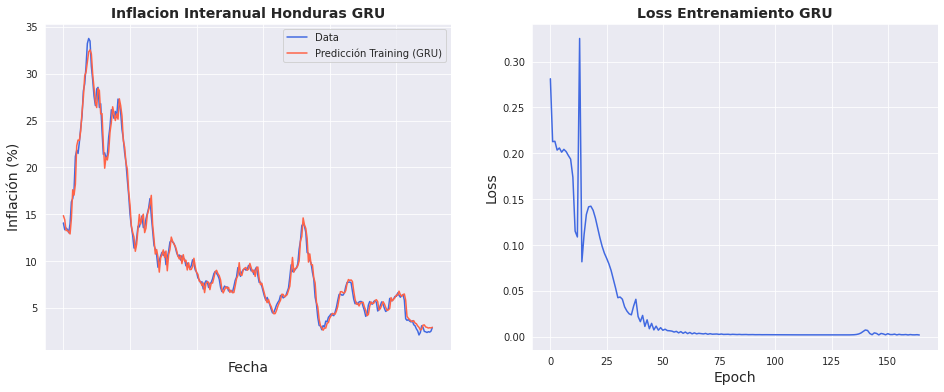

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Predicción Training (GRU)", color='tomato')
ax.set_title('Inflacion Interanual Honduras GRU', size = 14, fontweight='bold')
ax.set_xlabel("Fecha", size = 14)
ax.set_ylabel("Inflación (%)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Loss Entrenamiento GRU", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Puntuación Train: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(' Puntuación Test: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Puntuación Train: 0.89 RMSE
 Puntuación Test: 0.41 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(precio)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(precio)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(precio)-1, :] = y_test_pred

original = scaler.inverse_transform(precio['Inflacion'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Predicción Train')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Predicción Test'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Valores Actuales')))
fig.update_layout(
    xaxis=dict(
        title_text = "Tiempo",
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Inflación (%)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Resultados (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='Jisaula', api_key='N7TjAqxF7YSxv7SXtDeW')
py.iplot(fig, filename='Inflacion_prediction_gru')



```
# Comparación metricas de rendimiento
```



In [ ]:
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.684619,0.890026
Test RMSE,0.463953,0.410552
Train Time,21.834406,29.521803
